### Experiment:  Establish a Base-line Measurement of model hallucination

**Background:**  There are several metrics which are indicative of hallucination.  
Specifcically we will look at _Answer Faithfulness_ as it identifies deviations from provided context which would likely be hallucinated:

* [Answer Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html) - measures the factual consistency of generated answer vs. given context.

Secondarily the following provide indications of total RAG system effectiveness at generating a correct answer:

* [Answer Similarity](https://docs.ragas.io/en/stable/concepts/metrics/semantic_similarity.html) - (aka Answer Semantic Similarity) which is the simple cosine similarity of the generated and ground-truth answer.
* [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html) - measures the accuracy of the generated answer when compared to the ground truth answer.

**Test Approach:** A sample of questions will be selected from QA corpus.  Answers to questions will be generated via "v0" RAG implementation (excluding mitigation and advanced processing).  The above measures will be generated to establish a baseline of comparison for future experiments.

In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import os
os.environ["http_proxy"] = ''

In [33]:
# Common import
from deh.assessment import QASetRetriever
from deh import settings
from deh.eval import generate_experiment_dataset

import pandas as pd
import json
import os
from pathlib import Path

#### Test Configuration

In [34]:
num_samples:int = 100
experiment_folder:str = "../../data/evaluation/baseline-v0/"
qa_data_set_file:str = "../../data/qas/squad_qas.tsv"

# Create experiment folder:
if not os.path.exists(experiment_folder):
    Path(experiment_folder).mkdir(parents=True, exist_ok=True)

#### Sample QA dataset

In [35]:
qa_set = QASetRetriever.get_qasets(
    file_path = qa_data_set_file,
    sample_size= num_samples
)

print(f"{len(qa_set)} questions sampled from QA corpus ({qa_data_set_file})")

100 questions sampled from QA corpus (../../data/qas/squad_qas.tsv)


In [36]:
def api_endpoint(**kwargs) -> str:
    """Endpoint for context retrieval."""
    hyde= False
    evaluation = False
    
    query_params = "&".join([f"{key}={kwargs[key]}" for key in kwargs])
    return f"http://{settings.API_ANSWER_ENDPOINT}/answer?h={hyde}&e={evaluation}&{query_params}"

def convert(response) -> pd.DataFrame:
    """Converts retrieved JSON response to Pandas DataFrame"""
    response_df = pd.json_normalize(
        data=response["response"], record_path="context", meta=["answer","question", "hyde", ["evaluation", "grade"]]
    )

    # Add reference/evaluation values:
    response_df["reference.ground_truth"] = response["reference"]["ground_truth"]
    response_df["reference.is_impossible"] = response["reference"]["is_impossible"]

    # Add full JSON response incase needed:
    response_df["json"] = json.dumps(response)
    return response_df

exp_df = generate_experiment_dataset(qa_set, convert, api_endpoint)

# Store the generated response:
exp_df.to_pickle( f"{experiment_folder}/baseline-response-v0.pkl" )
exp_df[0:1]


Processing 1 of 100 question/answer pairs.
Processing 2 of 100 question/answer pairs.
Processing 3 of 100 question/answer pairs.
Processing 4 of 100 question/answer pairs.
Processing 5 of 100 question/answer pairs.
Processing 6 of 100 question/answer pairs.
Processing 7 of 100 question/answer pairs.
Processing 8 of 100 question/answer pairs.
Processing 9 of 100 question/answer pairs.
Processing 10 of 100 question/answer pairs.
Processing 11 of 100 question/answer pairs.
Processing 12 of 100 question/answer pairs.
Processing 13 of 100 question/answer pairs.
Processing 14 of 100 question/answer pairs.
Processing 15 of 100 question/answer pairs.
Processing 16 of 100 question/answer pairs.
Processing 17 of 100 question/answer pairs.
Processing 18 of 100 question/answer pairs.
Processing 19 of 100 question/answer pairs.
Processing 20 of 100 question/answer pairs.
Processing 21 of 100 question/answer pairs.
Processing 22 of 100 question/answer pairs.
Processing 23 of 100 question/answer pair

,id,page_content,type,metadata.source,metadata.similarity_score,answer,question,hyde,evaluation.grade,reference.ground_truth,reference.is_impossible,json,reference_id
0,None,The flora of the city may be considered very r...,Document,/data/contexts/context_1089.context,0.250279,Warsaw's flora is very rich in species due to ...,Why is Warsaw's flora very rich in species?,False,,location,False,"{""response"": {""question"": ""Why is Warsaw's flo...",1


#### Generate Measures for Response

##### Evaluation Model Configuration

In [46]:
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.llms import Ollama
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Either local (Ollama) or remote (OpenAI) evaluation models can be used:

embedding = OllamaEmbeddings(
    base_url=settings.OLLAMA_URL,
    model=settings.ASSESSMENT_EMBEDDING_MODEL,
)

llm = Ollama(
    base_url=settings.OLLAMA_URL,
    model=settings.ASSESSMENT_LLM_MODEL,
)

openai_llm = ChatOpenAI(model="gpt-4o-mini")
openai_embedding = OpenAIEmbeddings()

##### Evaluation Responses

In [48]:
from datasets import Dataset
from ragas import evaluate
import ragas.metrics as metrics
from ragas.run_config import RunConfig

In [43]:
# Convert to Dataset
responses_df = pd.read_pickle(f"{experiment_folder}/baseline-response-v0.pkl")

responses_df = responses_df.groupby("reference_id").agg(
    retrieved_contexts = ('page_content', lambda x: list(x)),
    question = ('question','first'),
    ground_truth = ('reference.ground_truth', 'first'),
    answer = ('answer', 'first')
    )

responses_df[0:1]


,retrieved_contexts,question,ground_truth,answer
reference_id,,,,
1,[The flora of the city may be considered very ...,Why is Warsaw's flora very rich in species?,location,Warsaw's flora is very rich in species due to ...


In [49]:

responses_ds = Dataset.from_pandas( responses_df)

evaluation_ds = evaluate(
    dataset = responses_ds,
    metrics = [metrics.answer_similarity, metrics.faithfulness, metrics.answer_correctness],
    embeddings = openai_embedding,
    llm = openai_llm,
    run_config=RunConfig(
        max_workers=5
    ),
    raise_exceptions=False
)


Evaluating: 100%|██████████| 300/300 [08:50<00:00,  1.77s/it]


In [52]:
eval_df = evaluation_ds.to_pandas()

# Evaluation metadata
eval_df["evaluation.llm_model"] = "openai.gpt-4o-mini"
eval_df["evaluation.embedding_model"] = "openai.Text-embedding-ada-002-v2"

eval_df[0:2]

,question,contexts,answer,ground_truth,answer_similarity,faithfulness,answer_correctness,evaluation.llm_model,evaluation.embedding_model
0,Why is Warsaw's flora very rich in species?,[The flora of the city may be considered very ...,Warsaw's flora is very rich in species due to ...,location,0.737363,1.0,0.593432,openai.gpt-4o-mini,openai.Text-embedding-ada-002-v2
1,Going to jail accomplished what goal of civil ...,[Some civil disobedients feel it is incumbent ...,Going to jail as a form of civil disobedience ...,reminding their countrymen of injustice,0.801872,1.0,0.414749,openai.gpt-4o-mini,openai.Text-embedding-ada-002-v2


In [53]:
eval_df.to_pickle( f"{experiment_folder}/baseline-evaluation-openai-results-v0.pkl" )

##### Comparison vs. HHEM and Local Embedding (Work in Progress)

In [ ]:
#### Evaluation with HHEM
# https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html
from ragas.metrics import FaithulnesswithHHEM

# pip install transformers, torch

subset_responses_df = responses_df[0:50]

faithfulness_with_hhem = FaithulnesswithHHEM()

evaluation_hhem_ds = evaluate(
    dataset = subset_responses_df,
    metrics = [faithfulness_with_hhem],
    embeddings = embedding,
    llm = openai_llm,
    run_config=RunConfig(
        max_workers=5
    ),
    raise_exceptions=False
)

#### Faithful vs. Non-Faithful Responses

In [78]:
faithfulness_threshold = 0.75 #75% of claims are considered supported by context.
ttl = len ( eval_df )
faithful = len( eval_df[ eval_df["faithfulness"] >= faithfulness_threshold ] )

print (f"% of responses indicated as faithful: {faithful/ttl*100}%")

% of responses indicated as faithful: 65.0%


#### Metric Trending Comparison

True


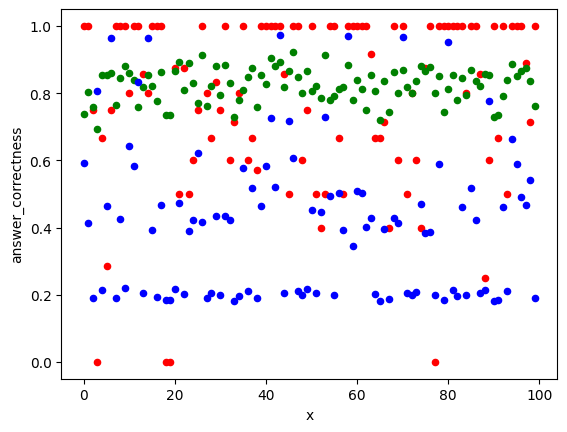

In [94]:
eval_df['x']=eval_df.index
ax1 = eval_df.plot(kind='scatter', x="x", y="faithfulness", color='r')
ax2 = eval_df.plot(kind='scatter', x="x", y="answer_similarity", color='g', ax=ax1)
ax3 = eval_df.plot(kind='scatter', x="x", y="answer_correctness", color='b', ax=ax1)


print(ax1==ax2==ax3)